# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')

In [3]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [4]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [5]:
etas_declustered = pd.read_csv('etas_declustered.csv')
catalog = pd.read_csv('catalog.csv')

## 4. Analyze correlation between all events (n=12573) and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [7]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [8]:
def calc_circle_cp_by_mascon(catalog, L_override=None):
    """
    Calculates conditional probability P(E|L) in every mascon using each mascon's center coordinates 
    and creating a 1.5 degree radius spherical cap around each one.
    If L_override is provided, it replaces the calculated L.
    """

    # Convert catalog to GeoDataFrame
    geometry = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
    catalog_gdf = gpd.GeoDataFrame(catalog, geometry=geometry, crs="EPSG:4326")  # Handle the earthquakes by "mascon"
    
    mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')

    lwe_data = ds['lwe_thickness']

    mascon_center_lat = mascon['mascon_lat'].data
    mascon_center_lon = mascon['mascon_lon'].data
    mascon_id = mascon['mascon_id'].data
    cap_radius_deg = 1.5  # Spherical cap radius in degrees

    cp = []

    # Create spatial index for catalog_gdf to optimize spatial joins
    catalog_gdf.sindex

    # Iterate through each mascon center
    # for i in tqdm(range(len(mascon_id)), miniters=500):
    for i in range(len(mascon_id)):
        # Create a Point for the mascon center
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])

        # Define a circular buffer (spherical cap) with a 1.5-degree radius
        bbox = center_point.buffer(cap_radius_deg)

        # Convert the buffer to a GeoDataFrame for spatial operations
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Spatial join to find earthquakes within the spherical cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # Skip to the next iteration if no earthquakes are found within this cap
        if these_earthquakes.empty:
            continue

        # Retrieve load data for this mascon using the center coordinates
        these_loads = lwe_data.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # Determine the value of L to use
        if L_override is not None:
            L = L_override  # Use provided L_override
        else:
            L = these_loads  # Use internally calculated L

        # Calculate conditional probabilities
        nt = 205  # per month
        ng = (1 - np.cos(cap_radius_deg * np.pi / 180)) / 2 * 510e6 / 1e5  # area per 100k square km
        LgE = these_earthquakes.dmass
        L = these_loads
        E = len(these_earthquakes) / nt / ng

        # Compute P(E|L)
        circle_bins, this_cp = get_cp(LgE, L)
        this_cp = this_cp * E
        cp.append(this_cp)

    # Average conditional probabilities across all mascons
    circle_cp_averaged = np.nanmean(np.array(cp), axis=0)
    
    return circle_cp_averaged, circle_bins

In [9]:
circle_cp_averaged, circle_bins = calc_circle_cp_by_mascon(catalog, L_override=None)

In [10]:
norm_cp_avg_full = circle_cp_averaged / ((1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)
np.sum(norm_cp_avg_full)

1.1255375188683976

## 5. Analyze correlation between events in declustered catalog (n=537) and surface mass loading by mascon

In [11]:
etas_circle_cp_averaged, etas_circle_bins = calc_circle_cp_by_mascon(etas_declustered, L_override=None)

In [12]:
max(etas_circle_cp_averaged)

0.0173155775087158

In [10]:
# '''
# Sanity Check!
# '''
# base = bbox_gdf.boundary.plot(color='red', linewidth=2)
# catalog_gdf.plot(ax=base, marker='o', color='blue', markersize=5, label='All Earthquakes')
# # these_earthquakes.plot(ax=base, marker='o', color='red', markersize=5, label='Selected Earthquakes')
# plt.xlim([-2,2])
# plt.ylim([-88,-92])
# plt.legend()
# plt.show()

In [15]:
etas_declustered[(etas_declustered.dmass > 2.5) & (etas_declustered.dmass < 6.5)]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass
1,1,1,22,24,-65.3437,-71.5089,2022-01-05 23:24:39.238,5.7,POINT (-65.3437 -71.5089),5.4,0.0,6.907373e-11,0.190957,0.809043,1.0,10.0,4.958631
4,4,4,107,109,82.1308,-17.6567,2021-11-23 12:04:19.226,5.4,POINT (82.13079999999999 -17.6567),5.4,0.0,6.907373e-11,0.519118,0.480882,1.0,10.0,3.625178
5,5,5,123,125,-26.5421,-13.6766,2021-11-12 00:34:16.787,5.8,POINT (-26.5421 -13.6766),5.4,0.0,6.907373e-11,0.802621,0.197379,1.0,10.0,4.760821
6,6,6,149,151,4.4561,147.2747,2021-10-22 07:27:53.884,5.4,POINT (4.4561 147.2747),5.4,0.0,6.907373e-11,0.604425,0.395575,1.0,10.0,6.156772
11,11,11,312,314,-59.7858,159.5461,2021-08-08 22:19:11.094,5.5,POINT (-59.7858 159.5461),5.4,0.0,6.907373e-11,0.881057,0.118943,1.0,10.0,3.907823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,480,480,11895,11897,28.3550,54.1690,2003-07-10 17:06:37.660,5.8,POINT (28.355 54.169),5.4,0.0,6.907373e-11,0.863467,0.136533,1.0,10.0,2.663075
482,482,482,11904,11906,76.3720,23.2820,2003-07-04 07:16:44.720,5.5,POINT (76.372 23.282),5.4,0.0,6.907373e-11,0.076098,0.923902,1.0,10.0,3.177964
505,505,505,12258,12260,-5.5250,36.0350,2002-11-04 03:19:18.380,5.5,POINT (-5.525 36.035),5.4,0.0,6.907373e-11,0.445903,0.554097,1.0,10.0,3.625425
513,513,513,12362,12364,66.9380,-18.4560,2002-09-16 18:48:26.720,5.8,POINT (66.938 -18.456),5.4,0.0,6.907373e-11,0.467553,0.532447,1.0,10.0,2.503306


## 6. Significance testing

### The code below does the following:
1. Scramble loads (ds.lwe_thickness) and generate randomized data
2. Calculate cp for each randomized load dataset

In [16]:
# Flatten the surface load dataset to scramble
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()  # Random number generator

cp_real_distribution = []
N = 1000  # Number of randomizations

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    scrambled_data = rng.permutation(all_grace_data)
    circle_cp_averaged, circle_bins = calc_circle_cp_by_mascon(catalog, L_override=scrambled_data)
    cp_real_distribution.extend(circle_cp_averaged)

cp_real_distribution = np.array(cp_real_distribution)

100%|███████████████████████████████████| 1000/1000 [28:36:47<00:00, 103.01s/it]


###  Repeating analysis for ETAS declustered catalog

In [17]:
# Flatten the surface load dataset to scramble
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()  # Random number generator

etas_cp_real_distribution = []
N = 1000  # Number of randomizations

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    scrambled_data = rng.permutation(all_grace_data)
    etas_circle_cp_averaged, etas_circle_bins = calc_circle_cp_by_mascon(etas_declustered, L_override=scrambled_data)
    etas_cp_real_distribution.extend(etas_circle_cp_averaged)

etas_cp_real_distribution = np.array(etas_cp_real_distribution)

100%|█████████████████████████████████████| 1000/1000 [5:40:07<00:00, 20.41s/it]


# Figures

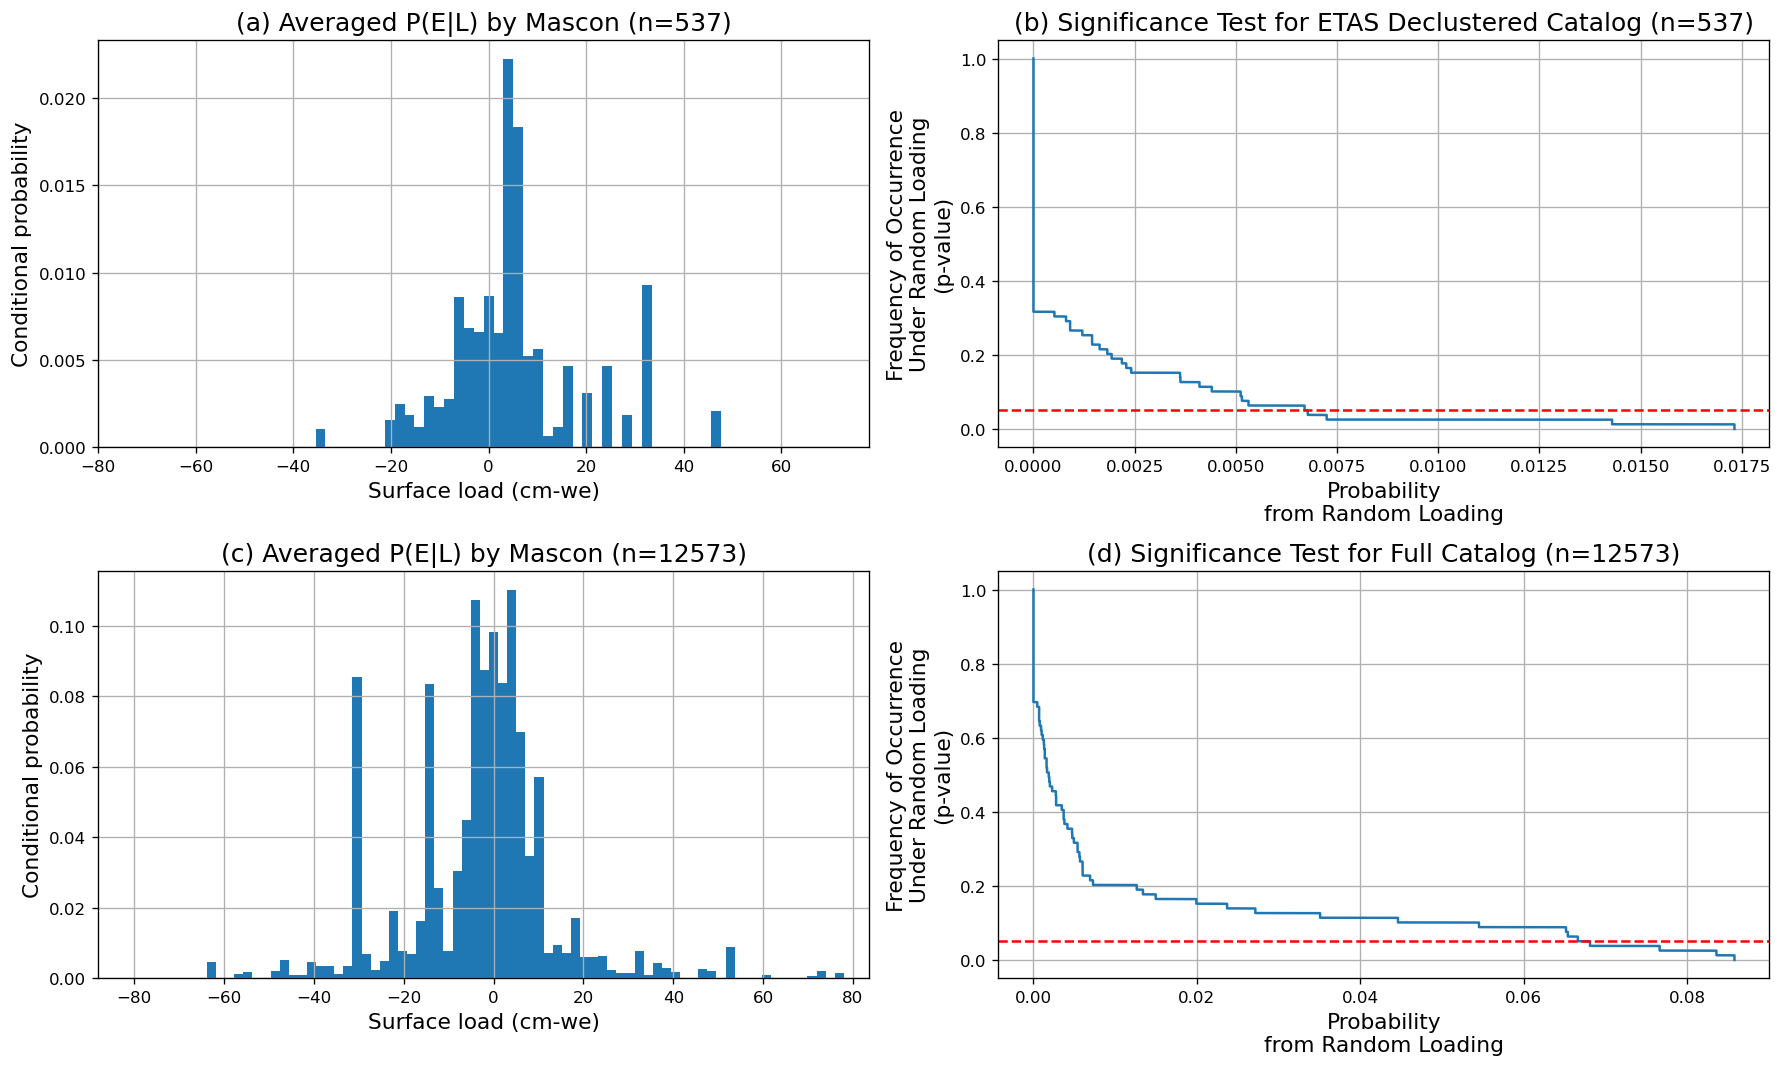

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(15,9), dpi=120)
fs = 13

# Top-left: (a) P(E|L) by Mascon (ETAS)
ax = axes[0, 0]  
wid_etas = np.mean(np.diff(etas_circle_bins))
norm_cp_avg_etas = etas_circle_cp_averaged / ((1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)

ax.bar(etas_circle_bins[:-1], norm_cp_avg_etas, width=wid_etas, align='edge')
ax.set_xlim(etas_circle_bins[0], etas_circle_bins[-2])
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
ax.grid(True)

# Top-right: (b) Significance test for ETAS declustered catalog
ax1 = axes[0, 1] 
etas_sorted_data = np.sort(etas_cp_real_distribution)
ax1.plot(etas_sorted_data, 1 - np.arange(etas_sorted_data.size) / etas_sorted_data.size)
ax1.axhline(y=0.05, color='r', linestyle='--')
# ax1.scatter(0.007, 0.05, c='r', zorder=29)
ax1.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax1.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax1.set_title('(b) Significance Test for ETAS Declustered Catalog (n=537)', fontsize=fs + 2)
ax1.grid(True)

# Bottom-left: (c) P(E|L) by Mascon (Full Catalog)
ax3 = axes[1, 0]  
wid = np.mean(np.diff(circle_bins))
norm_cp_avg_full = circle_cp_averaged / ((1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)
ax3.bar(circle_bins[:-1], norm_cp_avg_full, width=wid, align='edge')
xl = ax3.get_xlim()
ax3.set_xlim(xl[0], xl[1] - 4.4)
ax3.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax3.set_ylabel('Conditional probability', fontsize=fs)
ax3.set_title('(c) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
ax3.grid(True)

# Bottom-right: (d) Significance test for full catalog
ax2 = axes[1, 1] 
sorted_data = np.sort(cp_real_distribution)
ax2.plot(sorted_data, 1 - np.arange(sorted_data.size) / sorted_data.size)
# ax2.scatter(0.067, 0.05, c='r', zorder=29)
ax2.axhline(y=0.05, color='r', linestyle='--')
ax2.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
ax2.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
ax2.set_title('(d) Significance Test for Full Catalog (n=12573)', fontsize=fs + 2)
ax2.grid(True)

plt.tight_layout()
plt.show()


In [38]:
norm_cp_avg_full = circle_cp_averaged / ((1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)
np.sum(norm_cp_avg_full)

1.1255375188683976

In [39]:
norm_cp_avg_etas = etas_circle_cp_averaged / ((1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)
np.sum(norm_cp_avg_etas)

0.13232397342690733

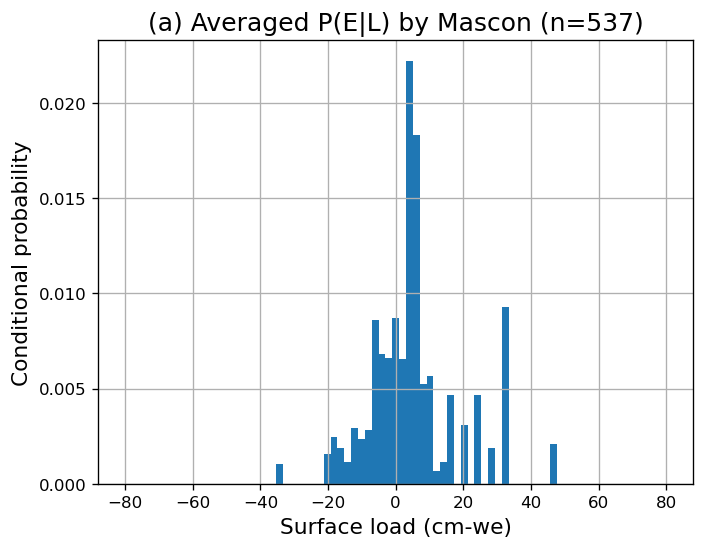

In [21]:
fig, ax = plt.subplots(dpi=120)
fs = 13

# Top-left: (a) P(E|L) by Mascon (ETAS)
wid_etas = np.mean(np.diff(etas_circle_bins))
norm_cp_avg_etas = etas_circle_cp_averaged / ((1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 4551)

ax.bar(etas_circle_bins[:-1], norm_cp_avg_etas, width=wid_etas, align='edge')
# ax.set_xlim(0,10)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('(a) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
ax.grid(True)